In [2]:
if not GATEWAY:
    %matplotlib inline

import matplotlib

if GATEWAY:
    matplotlib.use('agg')

In [3]:
# imports
import pandas as pd
import numpy as np

import re
import json
import yaml

import copy

# charts and plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import base64
import io
import sys
import urllib.parse

from chardet.universaldetector import UniversalDetector

#scikit
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn import tree

import hdbscan

from sklearn.externals.six import StringIO
from IPython.display import Image  

from wordcloud import WordCloud

In [4]:
#settings
np.set_printoptions(threshold=np.inf)

In [5]:
# hierarchical apply function on mixed dict/list struct
def map_nested_struct_modify(ob, func):
    if isinstance(ob,list):
        for v in ob:
            if isinstance(v,list) or isinstance(v,dict):
                map_nested_struct_modify(v, func)
            else:
                v = func(v)    
    elif isinstance(ob,dict):
        for k, v in ob.items():
            if isinstance(ob[k],list) or isinstance(ob[k],dict):
                map_nested_struct_modify(v, func)
            else:
                ob[k] = func(v)
    else:
        ob = func(ob)

In [6]:
if not GATEWAY:
    path='.'
else:
    path='/srv/notebooks'
    
datapath = "{}/datasets".format(path)

datasets = [
        {'id': '0', 'filename':'titanic.csv', 'desc':'Master of Life'},
        {'id': '1', 'filename':'iris.csv',    'desc':'So many flowers'},
        {'id': '2', 'filename':'pokemon.csv', 'desc':'Gotta catch \'em all!'},
        {'id': '3', 'filename':'boston.csv',  'desc':'Live and let live'}
]

df = pd.DataFrame()

df_meta = {
    'id'       : '',
    'file'     : {},
    'name'     : '',
    'desc'     : '',
    'vars'     : []
}

clusterer = None
clusterer_id = None
clusterer_X = None

In [7]:
REQUEST = json.dumps({
    'path' : {},
    'args' : {}
})

In [8]:
def response_dict(d, content_type='application/json'):
    if content_type == 'application/json':
        if GATEWAY:
            print(json.dumps(d))
        else:
            print(json.dumps(d, indent=4, sort_keys=True))
    elif content_type == 'application/base64':
        print(d)
    elif content_type == 'application/xml' or content_type == 'text/xml':
        print(yaml.dump(d))

def response_meta(status=200, content_type='application/json'):
    print(json.dumps({
        "headers" : { "Content-Type" : content_type},
        "status" : status
    }))

In [9]:
def uniquify(seq): 
    checked = dict()
    uniq = []
    for e in seq:
        if e not in checked.keys():
            if e:
                checked[e]=0
                uniq.append(e)
            else:
                checked[e]=1
                uniq.append('_1')
        else:
            checked[e] += 1
            uniq.append('{}_{}'.format(e,checked[e]))
    return uniq

def to_alphanum(s):
    return re.sub(r'[^0-9A-Za-z._]+', '', s).lower()

def prep_names(seq):
    names = [ to_alphanum(x)  for x in seq]
    return uniquify(names)

def dtype_to_string(x):
    return {
        'b': 'bool',
        'i': 'long',
        'u': 'long',
        'f': 'double',
        'c': 'complex',
        'O': 'object',
        'S': 'char',
        'a': 'char',
        'U': 'string',
        'V': 'raw'
    }.get(x[1], 'unknown')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def is_float(s):
    try:
        float(s) # for int, long, float
    except ValueError:
        return False
    return True

def is_int(s):
    try:
        return float(s).is_integer() # for int, long, float
    except ValueError:
        return False

def is_infinite(s):
    try:
        return np.isinf(float(s)) # for int, long, float
    except ValueError:
        return False

def is_zero(s):
    return not s

def vector_purity(x):
    for i in list(range(len(x))):
        # hard compressor
        x[i] = max(0, min(1, x[i]))
    return max(x)*(1 - (sum(x)-1)/(len(x)-1))

def get_typestats(sr):
    infinite= sum(sr.apply(is_infinite))
    real    = sum(sr.apply(is_number))
    integer = sum(sr.apply(is_int))
    nan     = sum(sr.isnull())
    zero    = sum(sr.apply(is_zero))
    unique  = len(sr.unique())
    
    unique  = unique - (1 if nan else 0)
    count   = len(sr)
    valid   = count-nan
        
    real = real - integer - nan
    numeric = real + integer
    string = count - real - integer - nan
    
    valid_ratio   = valid/count if count else 0
    unique_ratio  = unique/valid if valid else 0
    integer_ratio = integer/valid if valid else 0
    real_ratio    = real/valid if valid else 0
    string_ratio  = string/valid if valid else 0
    numeric_ratio = numeric/valid if valid else 0

    tpurity = vector_purity([integer_ratio, real_ratio, string_ratio])

    #coerce to number with string
    #require dealing with NA's
    
    if string>0:
        tcoerce = 'string' 
    else:    
        if integer_ratio>0.5 :
            tcoerce = 'integer'
        elif numeric_ratio>0.5 :
            tcoerce = 'real'
        else:
            tcoerce = 'real'
    
    # log vs linear?
    cat = False
    if (unique_ratio)<0.1 :
        cat = True
    
    ordinal = False
    if tcoerce=='integer' or tcoerce=='real':
        # correlation based
        corr = np.corrcoef(sr, list(range(count)))
        if (abs(corr[0,1])>0.95) : 
            ordinal = True
                        
        #weak
        if  unique_ratio >0.9 : 
            ordinal = True
    
    if cat:
        vtype = 'categorical'
    elif tcoerce=='real':
        vtype = 'continuous'
    elif tcoerce=='integer' :
        vtype = 'ordinal' if ordinal else 'descrete'
    else:
        vtype = 'unstructured'
        
    
    d = { 
          'infinite': infinite,
          'real'    : real,
          'integer' : integer,
          'nan'     : nan,
          'zero'    : zero,
          'string'  : string,
          'unique'  : unique,
          'valid'   : valid,
          'quality' : valid_ratio*tpurity,
          'cat'     : cat,
          'vtype'   : vtype,
          'tcoerce' : tcoerce,
          'tpurity' : tpurity,
          'dtype'   : dtype_to_string(sr.dtype.str)
    }
    
    return d

def numpy2py(ob):
    return np.asscalar(ob) if isinstance(ob, np.generic) else ob

def format_float(ob):
    return float(format(ob,'.2f')) if isinstance(ob, float) else ob

def numpy_tojson(ob):
    map_nested_struct_modify(ob, numpy2py)
    map_nested_struct_modify(ob, format_float)
    return ob

def sizeof_fmt(num, suffix='B'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def detect_encoding(filename):
    f = open(filename, 'rb')
    detector = UniversalDetector()
    for line in f:
        detector.feed(line)
        if detector.done: break
    detector.close()
    f.close()
    return detector.result

In [10]:
prep_names(['Type', 'lAbel','aaarg#$!%#', 'label;'])

['type', 'label', 'aaarg', 'label_1']

In [11]:
# TEST
sr = pd.Series([1,0.0, '', '', np.inf, np.nan, 2.9, '0', '111', 'kkk'])
get_typestats(sr)

{'cat': False,
 'dtype': 'object',
 'infinite': 1,
 'integer': 4,
 'nan': 1,
 'quality': 0.39999999999999997,
 'real': 2,
 'string': 3,
 'tcoerce': 'string',
 'tpurity': 0.44444444444444442,
 'unique': 8,
 'valid': 9,
 'vtype': 'unstructured',
 'zero': 3}

In [12]:
# help functions
def rows_na_any(df):
    na_df = pd.isnull(df)
    d = na_df.apply(np.any, axis=0)
    return len(d[d==True])

def col_na_any(df):
    na_df = pd.isnull(df)
    d = na_df.apply(np.any, axis=1)
    return len(d[d==True])

In [13]:
def load_dataset(id):
    global datasets, df, df_meta

    dataset = None
    for item in datasets:
        if id == item['id']:
            dataset = item
            break;
            
    if not dataset:
        return False
    
    filename = dataset.get('filename', None)
    
    #check if it's already loaded
    if id==df_meta['id']:
        return True
    
    if filename:
        filepath = "{}/{}".format(datapath,filename)
        df = pd.read_csv(
            filepath, 
            sep=None, 
            engine='python', 
            true_values=['True', 'true'], 
            false_values=['False','false']
        )

        #dataset id
        df_meta['id']       = id
        df_meta['desc']     = item.get('desc','')
        df_meta['name']     = item.get('name',filename.split('.')[0].title())
        df_meta['vars']     = [ {'id':str(i), 'alias' : k , 'name': v} for i,k,v in zip(list(range(len(df.columns))),prep_names(df.columns),df.columns) ]
    
        df_meta['file'] = {
            'path'      : filepath,
            'name'      : item['filename'],
            'size'      : sizeof_fmt(os.path.getsize(filepath)),
            'encoding'  : detect_encoding(filepath) 
        }
        
        #rename df columns
        df.columns = prep_names(df.columns)
        
        i=0
        for colname in df.columns:
            sr = df[colname]
            df_meta['vars'][i].update( {'type' : get_typestats(sr) } )
            i += 1
        
        return True
    else:
        df = pd.DataFrame()
        df_meta['id']   = id
        df_meta['file'] = {}
        df_meta['name'] = ''
        df_meta['desc'] = ''
        df_meta['vars'] = []
        
        return False

In [14]:
# TEST
#load_dataset('2')
#json.dumps(numpy_tojson(df_meta))

In [15]:
# GET /datasets

response_dict(datasets, 'application/json')

[
    {
        "desc": "Master of Life",
        "filename": "titanic.csv",
        "id": "0"
    },
    {
        "desc": "So many flowers",
        "filename": "iris.csv",
        "id": "1"
    },
    {
        "desc": "Gotta catch 'em all!",
        "filename": "pokemon.csv",
        "id": "2"
    },
    {
        "desc": "Live and let live",
        "filename": "boston.csv",
        "id": "3"
    }
]


In [16]:
# ResponseInfo GET /datasets

response_meta()

{"status": 200, "headers": {"Content-Type": "application/json"}}


In [17]:
# GET /datasets/:id

request = json.loads(REQUEST)
dataset_id = request['path'].get('id')

success = load_dataset(dataset_id)

if not success:
    response_dict('', 'application/json')
else:
    response_dict(numpy_tojson(df_meta), 'application/json')

""


In [18]:
# ResponseInfo GET /datasets/:id

status = 404 if not df_meta['id'] else 200
response_meta(status)

{"status": 404, "headers": {"Content-Type": "application/json"}}


In [19]:
df_meta

{'desc': '', 'file': {}, 'id': '', 'name': '', 'vars': []}

In [20]:
# GET /datasets/:id/stats

if not GATEWAY:
    REQUEST = json.dumps({'path': {'id':'1'}})

request = json.loads(REQUEST)
dataset_id = request['path'].get('id')

success = load_dataset(dataset_id)

if not success:
    response_dict('', 'application/json')
else:

    #cell data
    shape = df.shape

    dv = []

    #extract types
    for item in df_meta['vars']:
        sr = df[item['alias']]
        dv.append(
            {
                'id'    : item['id'],
                'alias' : item['alias'],
                'name'  : item['name'],
                'type'  : get_typestats(sr),
                'sample': [str(x) for x in sr.sample(n=10).tolist()]
            }
        )
    
    ds = copy.deepcopy(df_meta)
    ds.update({
        'dims': len(shape),
        'rows': shape[0],
        'cols': shape[1],
        'na': {
            'cols': rows_na_any(df),
            'rows': col_na_any(df)
        }
    })
    
    d = {
        'ds'  : ds,
        'vars': dv
    }

    #output
    response_dict(numpy_tojson(d), 'application/json')

{
    "ds": {
        "cols": 6,
        "desc": "So many flowers",
        "dims": 2,
        "file": {
            "encoding": {
                "confidence": 1.0,
                "encoding": "ascii"
            },
            "name": "iris.csv",
            "path": "./datasets/iris.csv",
            "size": "4.7KB"
        },
        "id": "1",
        "na": {
            "cols": 0,
            "rows": 0
        },
        "name": "Iris",
        "rows": 150,
        "vars": [
            {
                "alias": "unnamed0",
                "id": "0",
                "name": "Unnamed: 0",
                "type": {
                    "cat": false,
                    "dtype": "long",
                    "infinite": 0,
                    "integer": 150,
                    "nan": 0,
                    "quality": 1.0,
                    "real": 0,
                    "string": 0,
                    "tcoerce": "integer",
                    "tpurity": 1.0,
                    "un

In [21]:
# ResponseInfo GET /datasets/:id/stats

status = 404 if not df_meta['id'] else 200
response_meta()

{"status": 200, "headers": {"Content-Type": "application/json"}}


In [22]:
def describe(sr):
    d = dict(sr.describe())
    if '25%' in d.keys() : d['q25'] = d.pop('25%')
    if '50%' in d.keys() : d['q50'] = d.pop('50%')
    if '75%' in d.keys() : d['q75'] = d.pop('75%')
    
    try :
        d['skew'] = sr.skew()
        d['kurt'] = sr.kurt()
        d['mean'] = sr.mean()
    except:
        pass
        
    return d

def get_stats(sr, vtype):
    nan     = sum(sr.isnull())
    count   = len(sr)
    valid   = count-nan
    
    sr = sr[sr.notnull()]
    if vtype=='categorical':
        sr = sr.apply(lambda x: str(x))
        d = describe(sr)
        d.update({
            'categories': list(sr.unique()),
            'histogram': [{'v': str(x), 'c': y ,'p':y/valid} for x,y in sr.value_counts().items()]
        })
    elif vtype=='descrete' or vtype=='ordinal' or vtype=='continuos':
        d = describe(sr)
        
        b = matplotlib.cbook.boxplot_stats(sr)
        iqr  = b[0]['iqr']
        w_hi = b[0]['whishi']
        w_lo = b[0]['whislo']

        a_hi = sr[sr>w_hi].count()
        a_lo = sr[sr<w_lo].count()

        d.update({
            'iqr'      : iqr,
            'whiskers' : { 'hi':w_hi, 'lo':w_lo },
            'anomalies': { 'hi':a_hi, 'lo':a_lo }
        })
        

        d.update({
            'histogram': [{'v': x, 'c': y ,'p':y/valid} for x,y in sr.value_counts(bins=20, sort=False).items()]
        })
    else:
        sr = sr.apply(lambda x: str(x))
        d = describe(sr)
    return d

In [23]:
# GET /datasets/:id/variables/:vid

if not GATEWAY:
    REQUEST = json.dumps({'path': {'id':'0', 'vid':'7'}})

request = json.loads(REQUEST)
id = request['path'].get('id')
vid = request['path'].get('vid')

success = load_dataset(id)

if not success:
    response_dict('', 'application/json')
else:

    dv = {
        'id':vid
    }

    #extract types
    for item in df_meta['vars']:
        if vid == item['id']:
            sr = df[item['alias']]
            vardet = get_typestats(sr)
            dv.update(
                {
                    'id'    : item['id'],
                    'alias' : item['alias'],
                    'name'  : item['name'],
                    'type'  : vardet,
                    'sample': [str(x) for x in sr.sample(n=25).tolist()],
                    'stats' : get_stats(sr, vardet['vtype'])
                }
            )
            break
    
    id_num = int(float(vid))
    nav_prev = id_num-1 if 0 <= (id_num-1) else None
    nav_next = id_num+1 if (id_num+1)< len(df_meta['vars']) else None
    
    
    ds = copy.deepcopy(df_meta)
    
    d = {
        'ds'  : ds,
        'var': dv,
        'nav': {
            'prev':nav_prev,
            'next':nav_next
        }
    }

    #output
    response_dict(numpy_tojson(d), 'application/json')

{
    "ds": {
        "desc": "Master of Life",
        "file": {
            "encoding": {
                "confidence": 1.0,
                "encoding": "ascii"
            },
            "name": "titanic.csv",
            "path": "./datasets/titanic.csv",
            "size": "99.4KB"
        },
        "id": "0",
        "name": "Titanic",
        "vars": [
            {
                "alias": "pclass",
                "id": "0",
                "name": "pclass",
                "type": {
                    "cat": true,
                    "dtype": "double",
                    "infinite": 0,
                    "integer": 1309,
                    "nan": 1,
                    "quality": 1.0,
                    "real": 0,
                    "string": 0,
                    "tcoerce": "integer",
                    "tpurity": 1.0,
                    "unique": 3,
                    "valid": 1309,
                    "vtype": "categorical",
                    "zero": 0
       

In [24]:
# ResponseInfo GET /datasets/:id/variables/:vid

response_meta()

{"status": 200, "headers": {"Content-Type": "application/json"}}


In [31]:
import IPython

def response_png(imgdata=None):
    if GATEWAY:
        if type(imgdata) == IPython.core.display.Image :
            d = imgdata.data
        else:
            imgdata = io.BytesIO()
            plt.savefig(imgdata, format='png')
            imgdata.seek(0)  # rewind the data
            d = imgdata.read()

        data = urllib.parse.quote(base64.b64encode(d))
        return response_dict(data, 'application/base64')
    else:
        if type(imgdata) == IPython.core.display.Image :
            return imgdata

In [32]:
def get_seriename(id, vid=None, vtype=None):
    success = load_dataset(id)
    res= []
    if success:
        for item in df_meta['vars']:
            if vid == item['id'] :
                res.append(item['alias'])
                continue
                
            if vtype == item['type']['vtype'] :
                res.append(item['alias'])
                continue
    return res

def is_cat(id, vid):
    success = load_dataset(id)
    if success:
        for item in df_meta['vars']:
            if vid == item['id']:
                return item['type']['cat']
    return False

def get_serie(id, vid):
    colname = get_seriename(id, vid)
    return df[colname[0]] if colname else pd.Series([])

In [33]:
sr =  get_serie('0', '2')
get_stats(sr,get_typestats(sr)['vtype'])
get_typestats(sr)['vtype']

'unstructured'

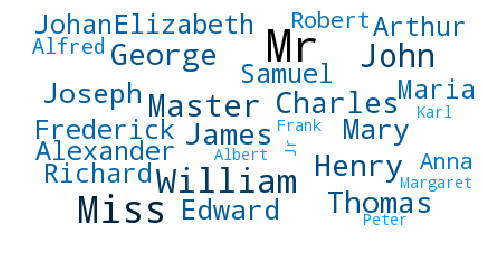

In [34]:
# GET /datasets/:id/variables/:vid/charts/1

if not GATEWAY:
    REQUEST = json.dumps({'path': {'id':'0', 'vid':'2'}})

request = json.loads(REQUEST)
id = request['path'].get('id')
vid = request['path'].get('vid')

sr=get_serie(id, vid)
vardet = get_typestats(sr)


plt.clf()
sns.set(style="white")
if vardet['vtype']=='categorical':
    d = get_stats(sr, vardet['vtype'])['histogram']
    dd = pd.DataFrame(d)
    s = sns.barplot(x='v', y='c', data=dd)
elif vardet['vtype']=='unstructured':
    import random
    def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(205, 100%%, %d%%)" % (80-font_size*2)

    text = ' '.join([str(x) for x in sr])
    wordcloud = WordCloud(max_font_size=40, max_words=30, relative_scaling=0.2, color_func=grey_color_func, background_color='white').generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
else :
    s = sns.distplot(sr, rug=True, hist=False,color="b")

response_png()

In [35]:
# ResponseInfo GET /datasets/:id/variables/:vid/charts/1

response_meta(200, 'application/base64')

{"status": 200, "headers": {"Content-Type": "application/base64"}}


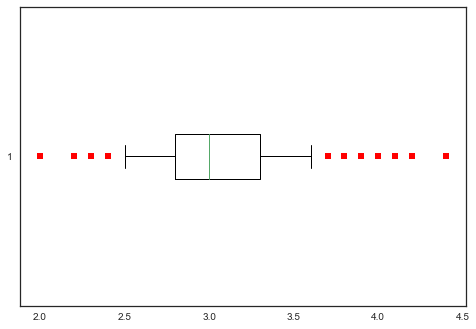

In [36]:
# GET /datasets/:id/variables/:vid/charts/2

if not GATEWAY:
    REQUEST = json.dumps({'path': {'id':'1', 'vid':'2'}})

request = json.loads(REQUEST)
id = request['path'].get('id')
vid = request['path'].get('vid')

sr=get_serie(id, vid)
vardet = get_typestats(sr)

if vardet['vtype']!='categorical' and vardet['vtype']!='unstructured':
    plt.clf()
    f = plt.boxplot(sr, 0, 'rs', 0, 0.75)
    response_png()

In [37]:
# ResponseInfo GET /datasets/:id/variables/:vid/charts/2

response_meta(200, 'application/base64')

{"status": 200, "headers": {"Content-Type": "application/base64"}}


In [38]:
load_dataset('0')
df_meta

{'desc': 'Master of Life',
 'file': {'encoding': {'confidence': 1.0, 'encoding': 'ascii'},
  'name': 'titanic.csv',
  'path': './datasets/titanic.csv',
  'size': '99.4KB'},
 'id': '0',
 'name': 'Titanic',
 'vars': [{'alias': 'pclass',
   'id': '0',
   'name': 'pclass',
   'type': {'cat': True,
    'dtype': 'double',
    'infinite': 0,
    'integer': 1309,
    'nan': 1,
    'quality': 0.99923664122137401,
    'real': 0,
    'string': 0,
    'tcoerce': 'integer',
    'tpurity': 1.0,
    'unique': 3,
    'valid': 1309,
    'vtype': 'categorical',
    'zero': 0}},
  {'alias': 'survived',
   'id': '1',
   'name': 'survived',
   'type': {'cat': True,
    'dtype': 'double',
    'infinite': 0,
    'integer': 1309,
    'nan': 1,
    'quality': 0.99923664122137401,
    'real': 0,
    'string': 0,
    'tcoerce': 'integer',
    'tpurity': 1.0,
    'unique': 2,
    'valid': 1309,
    'vtype': 'categorical',
    'zero': 809}},
  {'alias': 'name',
   'id': '2',
   'name': 'name',
   'type': {'cat': F

In [39]:
from sklearn import preprocessing

def to_vect(sr):
    d = sr.unique()
    t = dict(zip(d,range(len(d))))
    x = sr.map(lambda x: t[x] )
    return x

def C(sr):
    enc = preprocessing.OneHotEncoder()
    d = sr.unique()
    t = dict(zip(d,range(len(d))))
    x = [ [ t[x] ] for x in sr]
    return enc.fit_transform(x).toarray()

def colors(sr):
    c = cm.rainbow(np.linspace(0, 1, len(sr.unique())))
    x = [ c[x].tolist() for x in to_vect(sr)]
    return np.array(x)

In [40]:
# TEST 
load_dataset('2')
variable = 'type1'
#to_vect(df[variable])
#print(C(df[variable]))
#colors(df[variable])

In [41]:
len(df.columns)
get_seriename('2', str(6))
df_meta

{'desc': "Gotta catch 'em all!",
 'file': {'encoding': {'confidence': 0.938125, 'encoding': 'utf-8'},
  'name': 'pokemon.csv',
  'path': './datasets/pokemon.csv',
  'size': '43.0KB'},
 'id': '2',
 'name': 'Pokemon',
 'vars': [{'alias': '_1',
   'id': '0',
   'name': '#',
   'type': {'cat': False,
    'dtype': 'long',
    'infinite': 0,
    'integer': 800,
    'nan': 0,
    'quality': 1.0,
    'real': 0,
    'string': 0,
    'tcoerce': 'integer',
    'tpurity': 1.0,
    'unique': 721,
    'valid': 800,
    'vtype': 'ordinal',
    'zero': 0}},
  {'alias': 'name',
   'id': '1',
   'name': 'Name',
   'type': {'cat': False,
    'dtype': 'object',
    'infinite': 0,
    'integer': 0,
    'nan': 0,
    'quality': 1.0,
    'real': 0,
    'string': 800,
    'tcoerce': 'string',
    'tpurity': 1.0,
    'unique': 800,
    'valid': 800,
    'vtype': 'unstructured',
    'zero': 0}},
  {'alias': 'type1',
   'id': '2',
   'name': 'Type 1',
   'type': {'cat': True,
    'dtype': 'object',
    'infinite

In [42]:
#strong
np.corrcoef(df['_1'], df.index)[0,1]

#weak
len(df['_1'].unique())/df.shape[0] >0.9

len(df['_1'].unique())

721

In [43]:
v1 = get_seriename('0', vtype='descrete')
v2 = get_seriename('0', vtype='continuous')
v1 + v2

[]

In [44]:
def auto_clusterer(id):
    global clusterer, clusterer_id, clusterer_X
    
    if (clusterer_id == id) and clusterer:
        return clusterer_X

    # get numeric variables
    v1 = get_seriename(id, vtype='descrete')
    v2 = get_seriename(id, vtype='continuous')
    v = v1 + v2

    X = np.array(df[v] )

    # scale the features to a common scale
    scaler = preprocessing.MinMaxScaler()
    X = scaler.fit_transform(X)

    #apply tsne
    for i in list(range(2)):
        model = TSNE(n_components=2, verbose=0, n_iter=500, random_state=1337)
        X = model.fit_transform(X)
    
    # knn
    neigh = NearestNeighbors(n_neighbors=3)
    neigh.fit(X)  
    distances, indices = neigh.kneighbors(X)

    # statistics on the distance, take hi wisker
    d = np.mean(distances[:,1:3], axis=1)
    b = matplotlib.cbook.boxplot_stats(d)
    eps_best = b[0]['whishi']

    # dbscan: extract centroids
    dbscan = DBSCAN(eps=eps_best, min_samples=3).fit(X)
    c = pd.DataFrame(X, columns=['x','y'])
    c['l'] = dbscan.labels_
    c = c[c['l']!= -1]
    centroids = c.groupby('l').mean()
    centroids.loc[:,'n'] = c.groupby('l').count()
    centroids.loc[:,'c'] = centroids.index

    #linkage on clusters centers
    Z = hierarchy.linkage(centroids[['x', 'y']], 'ward')
    
    k = 8
    clusters = len(centroids['c'].unique())
    if clusters>k:
        centroids.loc[:,'h'] = fcluster(Z, k, criterion='maxclust')
    else:
        centroids.loc[:,'h'] = centroids['c']

    #take the smallest group, apply HDBSCAN
    min_size = centroids.groupby('h').sum()['n'].min()
    
    clusterer = hdbscan.HDBSCAN().fit(X)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=int(min_size), min_samples=1).fit(X)
    clusterer_id = id
    clusterer_X = X
    
    return clusterer_X

In [45]:
X = auto_clusterer('2')

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


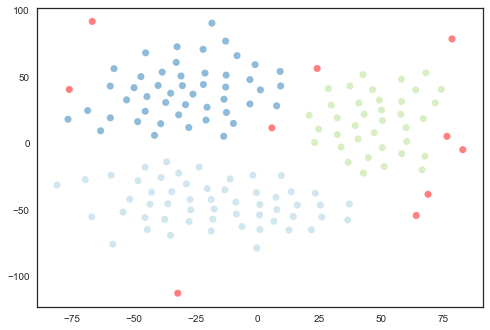

In [46]:
# GET /datasets/:id/clustering/charts/1

if not GATEWAY:
    REQUEST = json.dumps({'path': {'id':'1'}})

request = json.loads(REQUEST)
id = request['path'].get('id')

X = auto_clusterer(id)

color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (1, 0, 0)
                  for x in clusterer.labels_]
plt.clf()
f =plt.scatter(*X.T, s=50, linewidth=0, c=cluster_colors, alpha=0.5)
response_png()

In [47]:
# ResponseInfo GET /datasets/:id/clustering/charts/1

response_meta(200, 'application/base64')

{"status": 200, "headers": {"Content-Type": "application/base64"}}


In [48]:
# GET /datasets/:id/clustering/data

if not GATEWAY:
    REQUEST = json.dumps({'path': {'id':'1'}})

request = json.loads(REQUEST)
id = request['path'].get('id')

auto_clusterer(id)

color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (1, 0, 0)
                  for x in clusterer.labels_]
#plt.scatter(*X.T, s=50, linewidth=0, c=cluster_colors, alpha=0.5)
#print("# clusters: for ", min_size, np.unique(clusterer.labels_, ))
#plt.figure()
#unique, counts = np.unique(clusterer.labels_, return_counts=True)
#sns.barplot(x=unique, y=counts)
#silhouette_avg = silhouette_score(X, clusterer.labels_)
#print("The average silhouette_score for " , min_size, " is :", silhouette_avg)

unique, counts = np.unique(clusterer.labels_, return_counts=True)
d = [{"cl":x, "count":y} for x,y in zip([str(x) for x in unique], counts)]
response_dict(numpy_tojson(d), 'application/json')

[
    {
        "cl": "-1",
        "count": 10
    },
    {
        "cl": "0",
        "count": 55
    },
    {
        "cl": "1",
        "count": 48
    },
    {
        "cl": "2",
        "count": 37
    }
]


In [49]:
# ResponseInfo GET /datasets/:id/clustering/data

response_meta()

{"status": 200, "headers": {"Content-Type": "application/json"}}


In [51]:
# GET /datasets/:id/clustering/charts/2

if not GATEWAY:
    REQUEST = json.dumps({'path': {'id':'1'}})

request = json.loads(REQUEST)
id = request['path'].get('id')

auto_clusterer(id)


v1 = get_seriename(id, vtype='descrete')
v2 = get_seriename(id, vtype='continuous')
v = v1 + v2

DT = pd.DataFrame(df[v])
DT['labels'] = clusterer.labels_

#drop the outliers
#DT = DT[DT['labels']!=-1]
labels = [str(x) for x in np.unique(DT['labels'])]

clf = tree.DecisionTreeClassifier(max_leaf_nodes=len(labels), class_weight='balanced')
clf = clf.fit(DT[v], DT['labels'] )

# dot_data = StringIO()  
# tree.export_graphviz(clf, out_file=dot_data,  
#                          feature_names=v,  
#                          class_names=labels)  
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# imgdata = Image(graph.create_png())  
# response_png(imgdata)

In [52]:
# ResponseInfo GET /datasets/:id/clustering/charts/2

response_meta(200, 'application/base64')

{"status": 200, "headers": {"Content-Type": "application/base64"}}


In [53]:
#X = np.hstack( ( df[['total','hp','attack','defense','sp.atk', 'sp.def', 'speed']], C(df['type1']),C(df['type2']), C(df['generation']), C(df['legendary']) )  )
#X = np.array(df[['total','hp','attack','defense','sp.atk', 'sp.def', 'speed']] )

v1 = get_seriename('1', vtype='descrete')
v2 = get_seriename('1', vtype='continuous')
colnames = v1 + v2
#colnames = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']

X = np.array(df[colnames] )

print(X.shape)

scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)

for x in list(range(2)):
    model = TSNE(n_components=2, verbose=1, n_iter=500, random_state=1337)
    X = model.fit_transform(X)

(150, 4)
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.158839
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.392930
[t-SNE] Error after 375 iterations: 1.392930
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 19.731529
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.565908
[t-SNE] Error after 375 iterations: 1.565908


Explained variation per principal component: 0.537287960455521
[-0.4277524  -0.90389595]


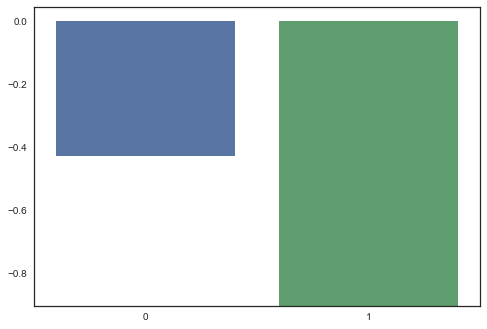

In [54]:
pca = PCA(n_components=1)
Y = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(sum(pca.explained_variance_ratio_)))
print(pca.components_[0])

d = pca.components_
sns.barplot(x=list(range(len(d[0]))), y=d[0])

In [55]:
print(X.shape)

model = TSNE(n_components=2, verbose=1, n_iter=500, random_state=1337)
X = model.fit_transform(X)

model = TSNE(n_components=2, verbose=1, n_iter=500, random_state=1337)
X = model.fit_transform(X)

(150, 2)
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 25.057268
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.655490
[t-SNE] Error after 375 iterations: 1.655490
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 29.228904
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.661281
[t-SNE] Error after 350 iterations: 1.661281


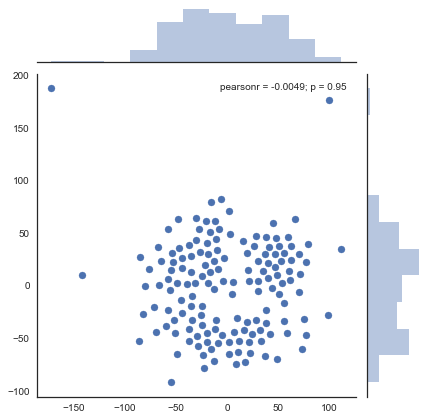

In [56]:
#D = np.hstack( (Y, df[['type2']].as_matrix()))
sns.jointplot(X[:,0], X[:,1])
#plt.scatter(X[:,0], X[:,1], c=colors(df['type1']))

In [57]:
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(X)  
distances, indices = neigh.kneighbors(X)
np.max(distances[:,1:3])

176.32439811185034

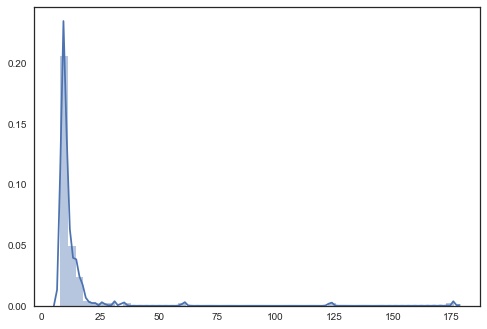

In [58]:
d = np.mean(distances[:,1:3], axis=1)
sns.distplot(d)

16.380272198763063

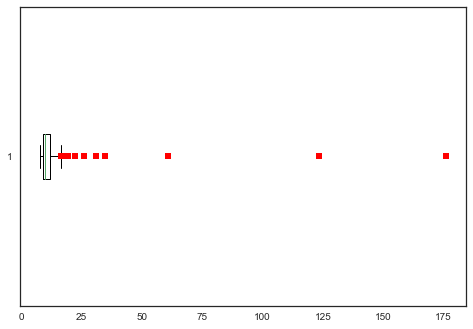

In [59]:
plt.boxplot(d, 0, 'rs', 0)
b = matplotlib.cbook.boxplot_stats(d)
eps_best = b[0]['whishi']
eps_best

In [60]:
clusterer = DBSCAN(eps=eps_best, min_samples=3).fit(X)
c = pd.DataFrame(X, columns=['x','y'])
c['l'] = clusterer.labels_
c = c[c['l']!= -1]
centroids = c.groupby('l').mean()
centroids.loc[:,'n'] = c.groupby('l').count()
centroids.loc[:,'c'] = centroids.index

In [61]:
centroids

,x,y,n,c
l,,,,
0,-1.569451,-1.027268,134,0
1,75.413507,-46.528313,3,1


16.3802721988
# clusters:  [-1  0  1]
13
The average silhouette_score for  16.3802721988  is : 0.141779301157


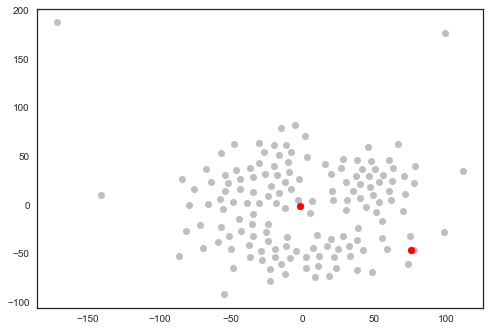

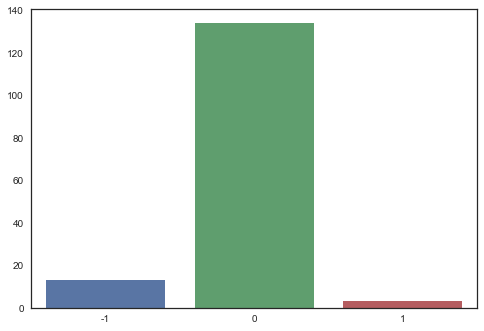

In [62]:
plt.scatter(*X.T, s=50, linewidth=0, c='grey', alpha=0.5)
plt.scatter(centroids['x'], centroids['y'], c='r')
print(eps_best)
print("# clusters: ", np.unique(clusterer.labels_))
plt.figure()
h = pd.Series.value_counts(clusterer.labels_)
sns.barplot(x=h.index, y=h.values)

min_size = int(h.quantile(0.50))

print(min_size)
silhouette_avg = silhouette_score(X, clusterer.labels_)
print("The average silhouette_score for " , eps_best, " is :", silhouette_avg)

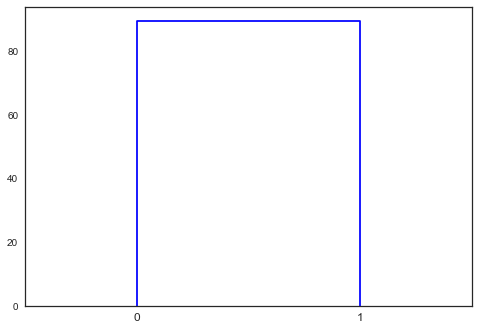

In [63]:
# agglomerative clustering on cluster centers

Z = hierarchy.linkage(centroids[['x', 'y']], 'ward')

dn = hierarchy.dendrogram(Z)
plt.show()

In [64]:
from scipy.cluster.hierarchy import fcluster

k = 8
clusters = len(centroids['c'].unique())
if clusters>k:
    centroids.loc[:,'h'] = fcluster(Z, k, criterion='maxclust')
else:
    centroids.loc[:,'h'] = centroids['c']
    
#take the smallest
min_size = centroids.groupby('h').sum()['n'].min()
min_size = min_size
min_size

3

In [65]:
centroids

,x,y,n,c,h
l,,,,,
0,-1.569451,-1.027268,134,0,0
1,75.413507,-46.528313,3,1,1


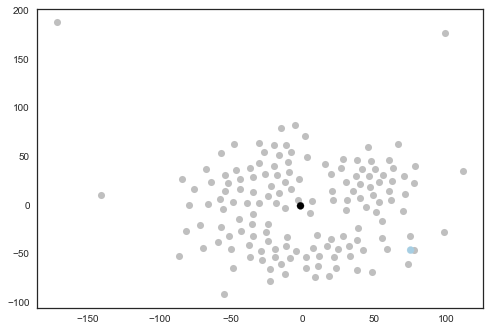

In [66]:
color_palette = sns.color_palette('Paired', len(centroids['h'].unique()) )
cluster_colors = [color_palette[x] if x >= 0
                  else (0, 0, 0)
                  for x in centroids['h']-1]

plt.scatter(*X.T, s=50, linewidth=0, c='grey', alpha=0.5)
plt.scatter(centroids['x'], centroids['y'], c=cluster_colors, s=50)

In [67]:
len(centroids['h'].unique())

2

In [68]:
# d = [0]
# for p in [ x for x in list(range(80,100)) ]:
#     eps = np.percentile(distances[:,1:3],p)
#     clusterer = DBSCAN(eps=eps, min_samples=3).fit(X)
#     silhouette_avg = 0 if len(np.unique(clusterer.labels_))<2 else silhouette_score(X, clusterer.labels_)
#     if silhouette_avg > max(d):
#         eps_best = eps
#     d.append(silhouette_avg)
#     print("The average silhouette_score for " , p, eps, " is :", silhouette_avg)

# plt.plot(d)

# eps_best

# clusters: for  3 [-1  0  1  2  3]
The average silhouette_score for  3  is : 0.129273036306


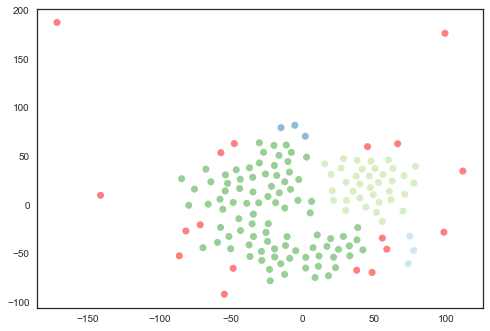

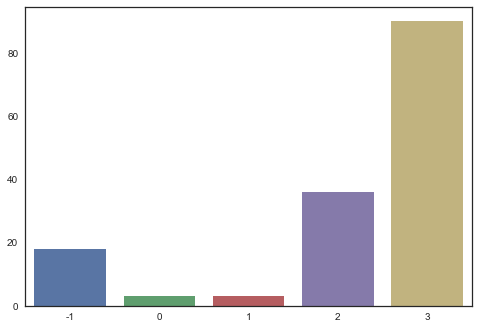

In [69]:
clusterer = hdbscan.HDBSCAN().fit(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=int(min_size), min_samples=1).fit(X)
color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (1, 0, 0)
                  for x in clusterer.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*X.T, s=50, linewidth=0, c=cluster_colors, alpha=0.5)
print("# clusters: for ", min_size, np.unique(clusterer.labels_, ))
plt.figure()
unique, counts = np.unique(clusterer.labels_, return_counts=True)
sns.barplot(x=unique, y=counts)
silhouette_avg = silhouette_score(X, clusterer.labels_)
print("The average silhouette_score for " , min_size, " is :", silhouette_avg)

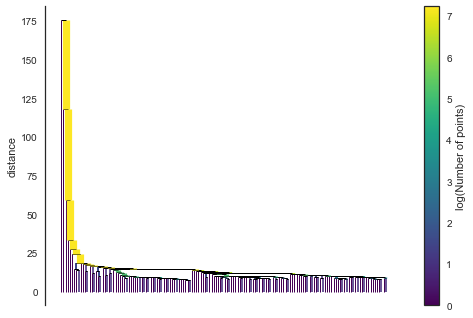

In [70]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

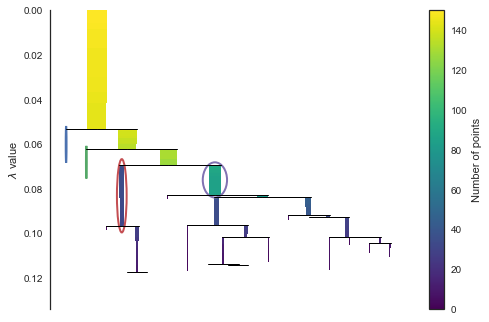

In [71]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [72]:
# d = []
# for s in [ x for x in list(range(5,30, 2)) ]:
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=s).fit(X)
#     silhouette_avg = silhouette_score(X, clusterer.labels_)
#     d.append(silhouette_avg)
#     print("The average silhouette_score for " , s, " is :", silhouette_avg)

# plt.plot(d)

In [73]:
from sklearn import tree

DT = pd.DataFrame(df[colnames])
DT['labels'] = clusterer.labels_

#drop the outliers
DT = DT[DT['labels']!=-1]
labels = [str(x) for x in np.unique(DT['labels'])]

clf = tree.DecisionTreeClassifier(max_leaf_nodes=len(labels), class_weight='balanced')
clf = clf.fit(DT[colnames], DT['labels'] )

In [74]:
labels

['0', '1', '2', '3']

In [75]:
colnames

['sepal.length', 'sepal.width', 'petal.length', 'petal.width']

In [76]:
leaves = (clf.tree_.children_left==-1) | (clf.tree_.children_right==-1)

In [77]:
np.mean(clf.tree_.impurity[leaves])

0.39285868778747673

In [78]:
clf.tree_.value[leaves]

array([[[ 22.        ,   0.        ,  10.08333333,   1.46666667]],

       [[  0.        ,   0.        ,  17.41666667,   2.93333333]],

       [[  0.        ,   0.        ,   1.83333333,  13.2       ]],

       [[ 11.        ,  33.        ,   3.66666667,  15.4       ]]])

In [79]:
clf.tree_.feature

array([ 2,  0,  1, -2, -2, -2, -2])

In [80]:
leaves

array([False, False, False,  True,  True,  True,  True], dtype=bool)

In [81]:
clf.tree_.threshold

array([ 4.85000038,  5.14999962,  2.8499999 , -2.        , -2.        ,
       -2.        , -2.        ])

nr of leafs:  4


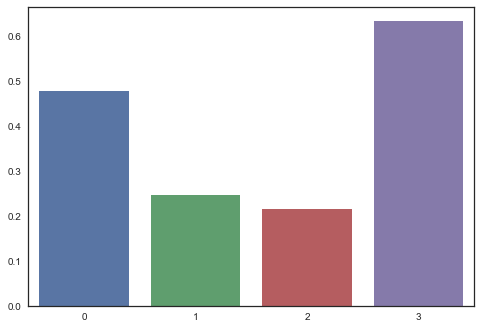

In [82]:
print("nr of leafs: ", sum(leaves))
gini = clf.tree_.impurity[leaves]
sns.barplot(x=list(range(sum(leaves))), y=gini)

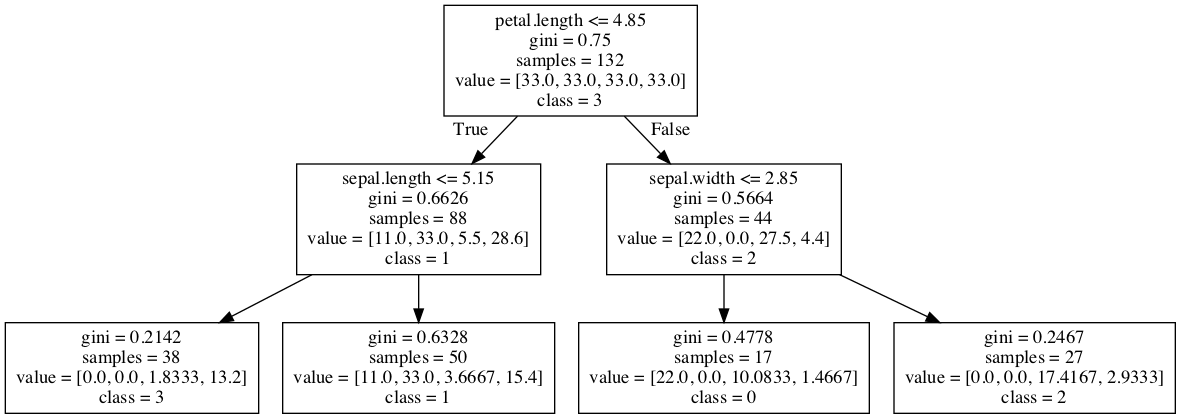

In [83]:
# import pydotplus
# from sklearn.externals.six import StringIO
# from IPython.display import Image  
# dot_data = StringIO()  
# tree.export_graphviz(clf, out_file=dot_data,  
#                          feature_names=colnames,  
#                          class_names=labels)  
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())